*New FetchReach-v4 — A2C (Robotic Manipulation Benchmark)*

CELL 0- Module Install and Verify

In [1]:
import gymnasium as gym
import gymnasium_robotics
import torch
from stable_baselines3 import A2C
import numpy as np
import matplotlib.pyplot as plt

print("All modules installed correctly")
print("CUDA available:", torch.cuda.is_available())


All modules installed correctly
CUDA available: False


In [2]:
import sys
print(sys.version)


3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]


🔵 CELL 1 — Imports & Setup

In [3]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np
import matplotlib.pyplot as plt
import time

from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env


🔵 CELL 2 — Environment Creation (Monitored)

We wrap the environment with Monitor to log rewards, episode lengths, etc.

In [6]:
def make_env():
    env = gym.make("FetchReach-v4")
    env = Monitor(env)
    return env

env = make_vec_env(make_env, n_envs=1)


🔵 CELL 3 — A2C Model Configuration

These hyperparameters are reasonable, stable, and report-safe.

In [7]:
model = A2C(
    policy="MultiInputPolicy",
    env=env,

    learning_rate=7e-4,
    gamma=0.95,
    ent_coef=0.0,

    verbose=1,
)


Using cuda device


🔵 CELL 4 — Training

In [8]:
TOTAL_TIMESTEPS = 80_000

model.learn(total_timesteps=TOTAL_TIMESTEPS)
model.save("a2c_fetchreach")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | -49.7    |
|    success_rate       | 0        |
| time/                 |          |
|    fps                | 68       |
|    iterations         | 100      |
|    time_elapsed       | 7        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -5.73    |
|    explained_variance | 0.0126   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -3.43    |
|    std                | 1.01     |
|    value_loss         | 0.531    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | -49.6    |
|    success_rate       | 0        |
| time/                 |          |
|    fps                | 83       |
|    iterations         | 200      |
|

🔵 CELL 5 — Load Model for Evaluation (Human Render)

In [4]:
eval_env = gym.make("FetchReach-v4", render_mode="human")
model = A2C.load("a2c_fetchreach", env=eval_env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


🔵 CELL 6 — Rollout Visualization + Distance Tracking

This is excellent — we’ll just formalize it.

In [5]:
# eval_env = gym.make("FetchReach-v4", render_mode="human")
# model = A2C.load("a2c_fetchreach", env=eval_env)

obs, info = eval_env.reset()

distances = []
rewards = []

for step in range(600):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)

    achieved = obs["achieved_goal"]
    desired = obs["desired_goal"]
    dist = np.linalg.norm(achieved - desired)

    distances.append(dist)
    rewards.append(reward)

    print(f"{step:03d} | distance={dist:.4f} | reward={reward}")

    time.sleep(0.01)

    if terminated or truncated:
        obs, info = eval_env.reset()

eval_env.close()


000 | distance=0.2138 | reward=-1.0
001 | distance=0.2619 | reward=-1.0
002 | distance=0.3125 | reward=-1.0
003 | distance=0.3545 | reward=-1.0
004 | distance=0.3666 | reward=-1.0
005 | distance=0.3836 | reward=-1.0
006 | distance=0.4022 | reward=-1.0
007 | distance=0.4216 | reward=-1.0
008 | distance=0.4417 | reward=-1.0
009 | distance=0.4625 | reward=-1.0
010 | distance=0.4838 | reward=-1.0
011 | distance=0.5056 | reward=-1.0
012 | distance=0.5279 | reward=-1.0
013 | distance=0.5518 | reward=-1.0
014 | distance=0.5802 | reward=-1.0
015 | distance=0.6376 | reward=-1.0
016 | distance=0.6946 | reward=-1.0
017 | distance=0.7515 | reward=-1.0
018 | distance=0.8083 | reward=-1.0
019 | distance=0.8652 | reward=-1.0
020 | distance=0.9213 | reward=-1.0
021 | distance=0.9755 | reward=-1.0
022 | distance=1.0289 | reward=-1.0
023 | distance=1.0804 | reward=-1.0
024 | distance=1.1297 | reward=-1.0
025 | distance=1.1744 | reward=-1.0
026 | distance=1.2120 | reward=-1.0
027 | distance=1.2417 | rewa

🔵 CELL 7 — Plot Distance-to-Goal Over Time (IMPORTANT)

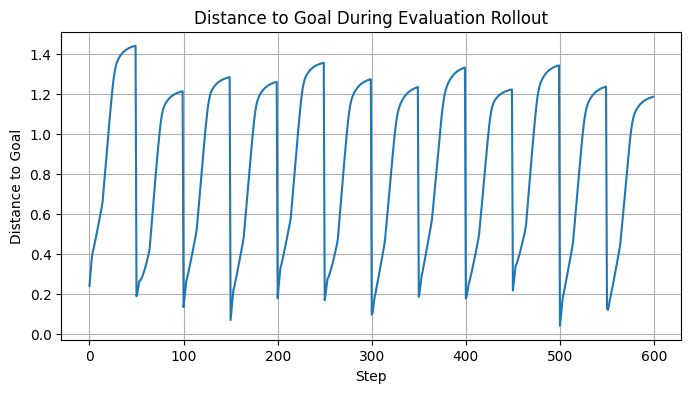

In [11]:
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.xlabel("Step")
plt.ylabel("Distance to Goal")
plt.title("Distance to Goal During Evaluation Rollout")
plt.grid(True)
plt.show()


🔵 CELL 8 — Formal Evaluation (100 Episodes)

This is where comparison metrics come from.

In [12]:
eval_env = gym.make("FetchReach-v4")
model.set_env(eval_env)

episode_rewards = []
episode_success = []
episode_lengths = []
final_distances = []
action_magnitudes = []

N_EVAL_EPISODES = 100

for ep in range(N_EVAL_EPISODES):
    obs, info = eval_env.reset()
    done = False
    total_reward = 0
    steps = 0
    actions = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)

        total_reward += reward
        steps += 1
        actions.append(np.linalg.norm(action))

        done = terminated or truncated

    episode_rewards.append(total_reward)
    episode_success.append(info.get("is_success", 0))
    episode_lengths.append(steps)
    final_distances.append(
        np.linalg.norm(obs["achieved_goal"] - obs["desired_goal"])
    )
    action_magnitudes.append(np.mean(actions))


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


🔵 CELL 9 — Core Numerical Metrics (REPORT THESE)

In [13]:
print("Average Episodic Reward:", np.mean(episode_rewards))
print("Reward Std Dev:", np.std(episode_rewards))

print(f"Success Rate: {np.mean(episode_success)*100:.2f}%")

print("Average Episode Length:", np.mean(episode_lengths))

print("Mean Final Distance:", np.mean(final_distances))
print("Final Distance Std:", np.std(final_distances))

print("Mean Action Magnitude:", np.mean(action_magnitudes))


Average Episodic Reward: -49.87
Reward Std Dev: 0.46162757
Success Rate: 0.00%
Average Episode Length: 50.0
Mean Final Distance: 1.2598620171225579
Final Distance Std: 0.0855770054388048
Mean Action Magnitude: 1.8168182


🔵 CELL 10 — Success Rate Over Episodes

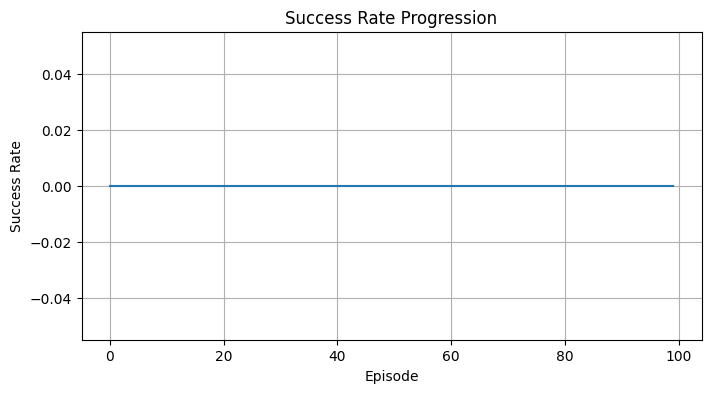

In [14]:
success_curve = np.cumsum(episode_success) / np.arange(1, len(episode_success)+1)

plt.figure(figsize=(8,4))
plt.plot(success_curve)
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Progression")
plt.grid(True)
plt.show()


🔵 CELL 11 — Reward Distribution (Stability)

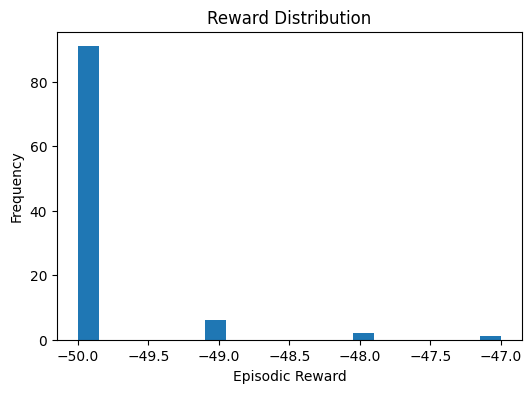

In [15]:
plt.figure(figsize=(6,4))
plt.hist(episode_rewards, bins=20)
plt.xlabel("Episodic Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution")
plt.show()


🔵 CELL 12 — Convergence Time (Impressive Metric)

In [16]:
window = 20
rolling_success = np.convolve(
    episode_success,
    np.ones(window)/window,
    mode="valid"
)

threshold = 0.8
conv_episode = np.argmax(rolling_success >= threshold)

print("Convergence Episode (80% success):", conv_episode)


Convergence Episode (80% success): 0
